In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym
from collections import deque
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
class StandardQLearning:
    def __init__(self, env):
        self.env = env
        self.q_table = np.zeros((env.observation_space.n, env.action_space.n))
        self.gamma = 0.99
        self.alpha = 0.1
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

    def get_action(self, state):
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.q_table[state])

    def update(self, state, action, reward, next_state):
        old_value = self.q_table[state, action]
        next_max = np.max(self.q_table[next_state])
        new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max)
        self.q_table[state, action] = new_value
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

class StochasticFactorizationQL:
    def __init__(self, env, embedding_dim=5):
        self.env = env
        self.state_dim = env.observation_space.n
        self.action_dim = env.action_space.n
        
        # Initialize model
        self.model = nn.Sequential(
            nn.Embedding(self.state_dim, embedding_dim),  # U(s)
            nn.Linear(embedding_dim, self.action_dim)     # V(a)
        )
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.criterion = nn.MSELoss()
        
        # Training parameters
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.memory = deque(maxlen=10000)
        
    def get_action(self, state):
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        
        with torch.no_grad():
            state_tensor = torch.tensor([state])
            q_values = self.model(state_tensor)
            return torch.argmax(q_values).item()
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        
        batch = random.sample(self.memory, batch_size)
        states = torch.tensor([x[0] for x in batch])
        actions = torch.tensor([x[1] for x in batch])
        rewards = torch.tensor([x[2] for x in batch], dtype=torch.float32)
        next_states = torch.tensor([x[3] for x in batch])
        dones = torch.tensor([x[4] for x in batch], dtype=torch.float32)
        
        # Current Q-values
        current_q = self.model(states).gather(1, actions.unsqueeze(1))
        
        # Target Q-values
        with torch.no_grad():
            next_q = self.model(next_states).max(1)[0]
            target_q = rewards + (1 - dones) * self.gamma * next_q
        
        # Update model
        self.optimizer.zero_grad()
        loss = self.criterion(current_q.squeeze(), target_q)
        loss.backward()
        self.optimizer.step()
        
        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        
        return loss.item()

In [3]:
def train_standard_q(env, episodes=1000):
    agent = StandardQLearning(env)
    scores = []
    
    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            action = agent.get_action(state)
            next_state, reward, done, _, _ = env.step(action)
                
            agent.update(state, action, reward, next_state)
            state = next_state
            total_reward += reward
            
        scores.append(total_reward)
    
    return scores

def train_stochastic_factorization(env, episodes=1000):
    agent = StochasticFactorizationQL(env)
    scores = []
    batch_size = 32
    
    for episode in tqdm(range(episodes), desc="Stochastic Factorization"):
        state, _ = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            action = agent.get_action(state)
            next_state, reward, done, _, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)
                
        scores.append(total_reward)
    
    return scores

In [4]:
def compare_methods(episodes=1000, runs=1):
    env = gym.make('CliffWalking-v0')
    all_standard_scores = []
    all_sf_scores = []
    
    for run in range(runs):
        print(f"\nRun {run + 1}/{runs}")
        standard_scores = train_standard_q(env, episodes)
        sf_scores = train_stochastic_factorization(env, episodes)
        
        all_standard_scores.append(standard_scores)
        all_sf_scores.append(sf_scores)
    
    # Average across runs
    avg_standard = np.mean(all_standard_scores, axis=0)
    avg_sf = np.mean(all_sf_scores, axis=0)
    
    # Calculate cumulative rewards
    cum_standard = np.cumsum(avg_standard)
    cum_sf = np.cumsum(avg_sf)
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    # Cumulative rewards
    plt.subplot(1, 2, 1)
    plt.plot(cum_standard, label='Standard Q-Learning')
    plt.plot(cum_sf, label='Stochastic Factorization')
    plt.title('Cumulative Reward')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.grid(True)
    
    # Moving average
    window = 100
    plt.subplot(1, 2, 2)
    plt.plot(np.convolve(avg_standard, np.ones(window)/window, mode='valid'), 
             label='Standard Q-Learning')
    plt.plot(np.convolve(avg_sf, np.ones(window)/window, mode='valid'), 
             label='Stochastic Factorization')
    plt.title(f'Moving Average Reward (Window={window})')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return avg_standard, avg_sf


Run 1/1


/opt/miniconda3/envs/env_gal/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Stochastic Factorization: 100%|██████████| 1000/1000 [00:28<00:00, 34.83it/s]


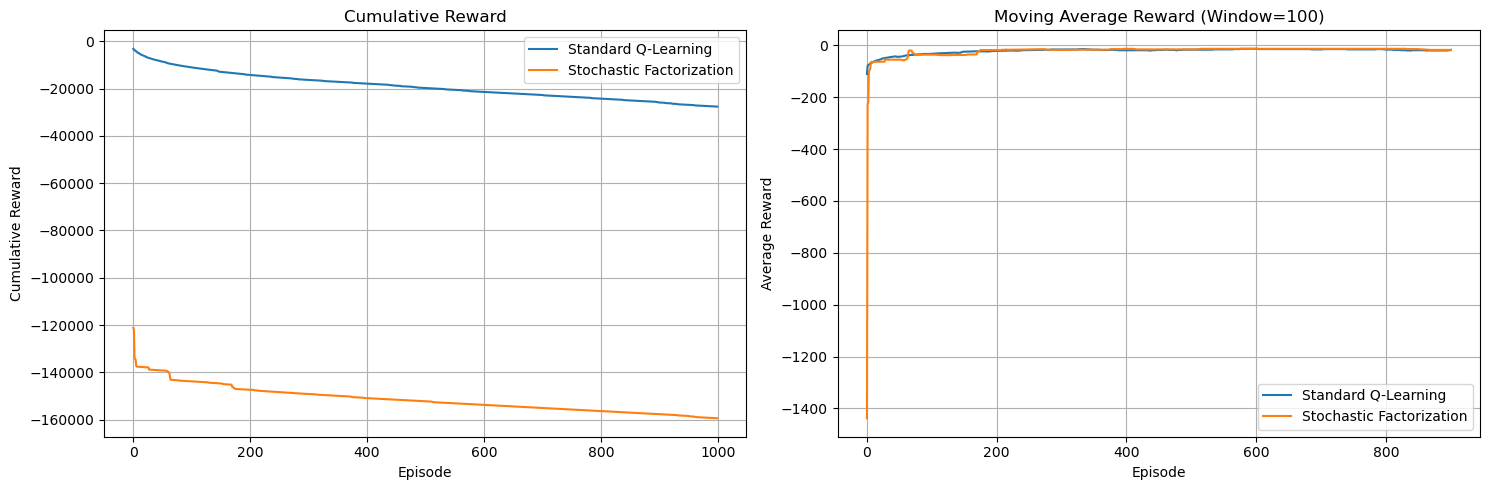


Final Statistics:
Standard Q-Learning - Last 100 episodes average: -17.470
Stochastic Factorization - Last 100 episodes average: -17.320


In [5]:
if __name__ == "__main__":
    avg_standard, avg_sf = compare_methods()
    
    print("\nFinal Statistics:")
    print(f"Standard Q-Learning - Last 100 episodes average: {np.mean(avg_standard[-100:]):.3f}")
    print(f"Stochastic Factorization - Last 100 episodes average: {np.mean(avg_sf[-100:]):.3f}")